In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
from __future__ import annotations

import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro_glm.utils.dist as dist_utils
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns

numpyro.set_host_device_count(4)

# Chapter 9: Hierarchical Models
## Multiple Coins from a Single Mint
### Example: Therapeutic Touch

In [3]:
therapeutic_df: pd.DataFrame = pd.read_csv(
    'datasets/TherapeuticTouchData.csv', dtype=dict(s='category'))
therapeutic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [4]:
def therapeutic_touch(y: jnp.ndarray, s: jnp.ndarray, nb_subjects: int):
    assert y.shape[0] == s.shape[0]

    nb_obs = y.shape[0]

    # Omega prior.
    omega = numpyro.sample('omega', dist.Beta(1, 1))

    # Kappa prior.
    kappa_minus_two = numpyro.sample(
        '_kappa-2', dist_utils.gamma_dist_from_mean_std(1, 10))
    kappa = numpyro.deterministic('kappa', kappa_minus_two + 2)

    # Each subject's ability.
    theta = numpyro.sample(
        'theta', dist_utils.beta_dist_from_omega_kappa(omega, kappa).expand([nb_subjects]))

    # Observations.
    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Bernoulli(theta[s[idx]]), obs=y[idx])

In [5]:
kernel = NUTS(therapeutic_touch)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(therapeutic_df['y'].values),
    s=jnp.array(therapeutic_df['s'].cat.codes.values),
    nb_subjects=therapeutic_df['s'].cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  _kappa-2     53.57     56.71     34.57      2.79    119.01   5707.19      1.00
     omega      0.44      0.04      0.44      0.38      0.50  24242.84      1.00
  theta[0]      0.36      0.09      0.37      0.21      0.50  19153.81      1.00
  theta[1]      0.38      0.08      0.39      0.24      0.52  27911.55      1.00
  theta[2]      0.41      0.08      0.41      0.27      0.54  45381.68      1.00
  theta[3]      0.41      0.08      0.41      0.27      0.53  46524.64      1.00
  theta[4]      0.41      0.08      0.41      0.27      0.54  46985.94      1.00
  theta[5]      0.41      0.08      0.41      0.27      0.54  45329.29      1.00
  theta[6]      0.41      0.08      0.41      0.28      0.54  42561.78      1.00
  theta[7]      0.41      0.08      0.41      0.27      0.53  45976.01      1.00
  theta[8]      0.41      0.08      0.41      0.27      0.54  45502.18      1.00
  theta[9]      0.41      0

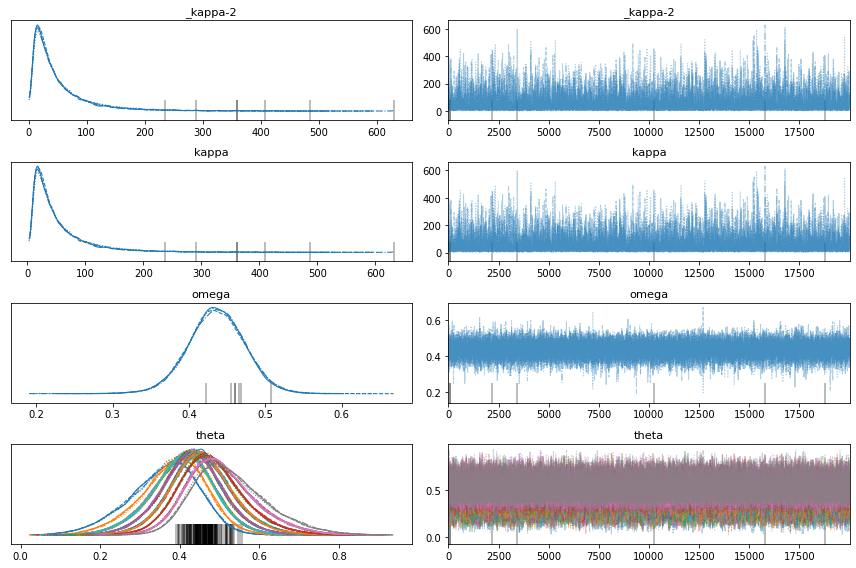

In [6]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(subject=therapeutic_df['s'].cat.categories),
    dims=dict(theta=['subject']))
az.plot_trace(idata)
plt.tight_layout()

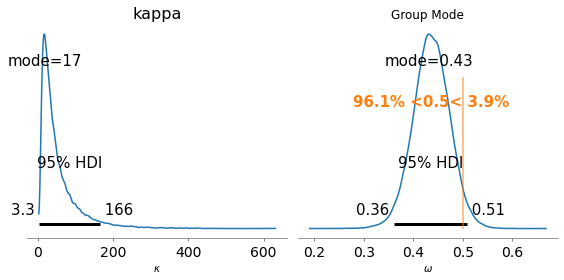

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax = axes[0]
az.plot_posterior(idata, var_names='kappa',
                  point_estimate='mode', hdi_prob=.95, ax=ax)
ax.set_xlabel('$\\kappa$')

ax = axes[1]
az.plot_posterior(idata, var_names='omega',
                  point_estimate='mode', hdi_prob=.95, ref_val=0.5, ax=ax)
ax.set_title('Group Mode')
ax.set_xlabel('$\\omega$')

fig.tight_layout()

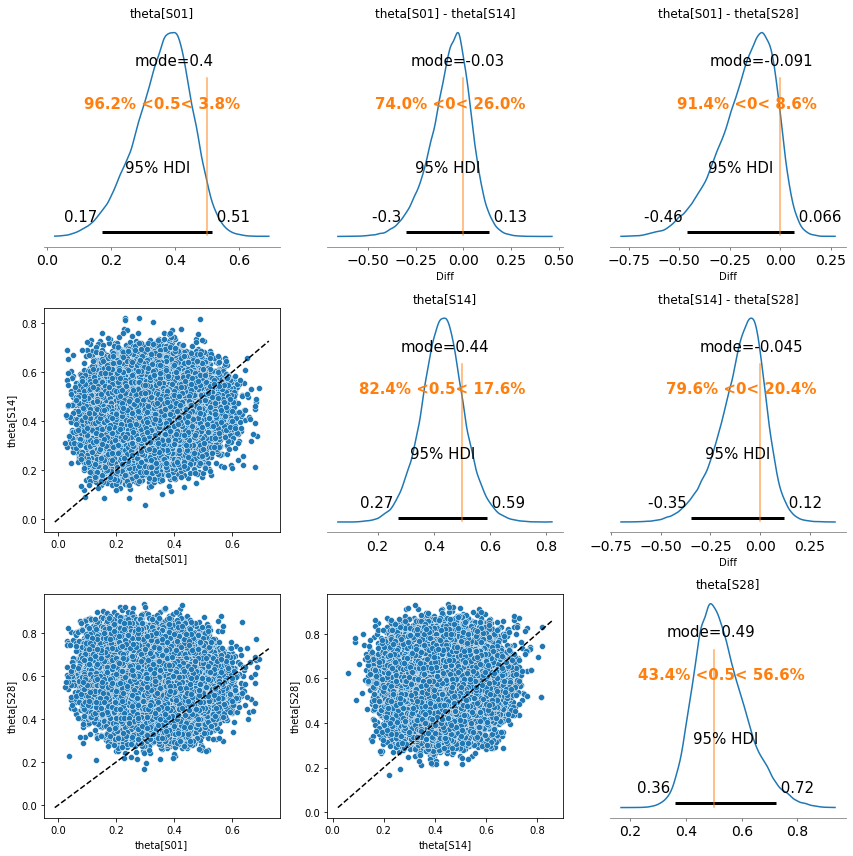

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
theta_to_plot = ['S01', 'S14', 'S28']

for r, c in np.ndindex(axes.shape):
    ax = axes[r, c]
    r_theta = theta_to_plot[r]
    c_theta = theta_to_plot[c]

    if r == c:
        az.plot_posterior(
            idata, 'theta',
            coords=dict(subject=r_theta),
            hdi_prob=.95,
            point_estimate='mode',
            ref_val=.5,
            ax=ax)
        ax.set_title(f'theta[{r_theta}]')
    elif r < c:
        diff = (idata['posterior']['theta'].sel(subject=r_theta).values
                - idata['posterior']['theta'].sel(subject=c_theta).values)
        az.plot_posterior(
            diff, hdi_prob=.95, point_estimate='mode', ref_val=0, ax=ax)
        ax.set_title(f'theta[{r_theta}] - theta[{c_theta}]')
        ax.set_xlabel('Diff')
    else:
        y = idata['posterior']['theta'].sel(subject=r_theta).values.flatten()
        x = idata['posterior']['theta'].sel(subject=c_theta).values.flatten()

        sns.scatterplot(x=x, y=y, ax=ax)

        xx = np.linspace(*ax.get_xlim(), 1000)
        sns.lineplot(x=xx, y=xx, ax=ax, color='k', linestyle='dashed')

        ax.set_xlabel(f'theta[{c_theta}]')
        ax.set_ylabel(f'theta[{r_theta}]')

fig.tight_layout()

## Extending the Hierarchy: Subjects within Categories
### Example: Baseball Batting Abilities by Position

In [9]:
baseball_df: pd.DataFrame = pd.read_csv(
    'datasets/BattingAverage.csv',
    dtype=dict(PriPos='category', Player='category'))
baseball_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Player        948 non-null    category
 1   PriPos        948 non-null    category
 2   Hits          948 non-null    int64   
 3   AtBats        948 non-null    int64   
 4   PlayerNumber  948 non-null    int64   
 5   PriPosNumber  948 non-null    int64   
dtypes: category(2), int64(4)
memory usage: 72.6 KB


In [10]:
def baseball_batting_model(y: jnp.ndarray, pos: jnp.ndarray, at_bats: jnp.ndarray, nb_pos: int):
    assert y.shape[0] == pos.shape[0] == at_bats.shape[0]
    nb_obs = y.shape[0]

    # All positions' overall ability.
    omega = numpyro.sample('omega', dist.Beta(1, 1))
    kappa_minus_two = numpyro.sample(
        '_kappa-2', dist_utils.gamma_dist_from_mean_std(1, 10))
    kappa = numpyro.deterministic('kappa', kappa_minus_two + 2)

    # Each position's ability.
    omega_pos = numpyro.sample(
        'omega_pos', dist_utils.beta_dist_from_omega_kappa(omega, kappa).expand([nb_pos]))
    kappa_pos_minus_two = numpyro.sample(
        '_kappa_pos-2', dist_utils.gamma_dist_from_mean_std(1, 10).expand([nb_pos]))
    kappa_pos = numpyro.deterministic('kappa_pos', kappa_pos_minus_two + 2)

    # Each player's ability.
    with numpyro.plate('obs', nb_obs) as idx:
        ability = numpyro.sample(
            'ability', dist_utils.beta_dist_from_omega_kappa(omega_pos[pos[idx]], kappa_pos[pos[idx]]))
        numpyro.sample('y', dist.Binomial(at_bats[idx], ability), obs=y[idx])


kernel = NUTS(baseball_batting_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(baseball_df['Hits'].values),
    pos=jnp.array(baseball_df['PriPos'].cat.codes.values),
    at_bats=jnp.array(baseball_df['AtBats'].values),
    nb_pos=baseball_df['PriPos'].cat.categories.size,
)
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       _kappa-2     59.49     32.01     54.02     12.26    107.82  44529.96      1.00
_kappa_pos-2[0]    236.56     68.53    226.93    128.99    338.48  30302.15      1.00
_kappa_pos-2[1]    256.53     81.84    244.05    131.93    380.63  25219.18      1.00
_kappa_pos-2[2]    209.90     66.28    199.68    108.17    308.58  27138.02      1.00
_kappa_pos-2[3]    169.73     46.67    163.19     97.58    240.99  23784.35      1.00
_kappa_pos-2[4]    238.20     76.26    226.62    119.14    350.46  28511.26      1.00
_kappa_pos-2[5]    213.56     62.76    204.17    118.69    308.78  19203.34      1.00
_kappa_pos-2[6]    105.69     46.41     95.11     43.67    167.25   2030.33      1.00
_kappa_pos-2[7]    399.76    134.66    379.04    192.04    601.17  27106.94      1.00
_kappa_pos-2[8]    240.97     83.56    227.52    113.00    363.70  25641.29      1.00
     ability[0]      0.13      0.03      0.13      0.

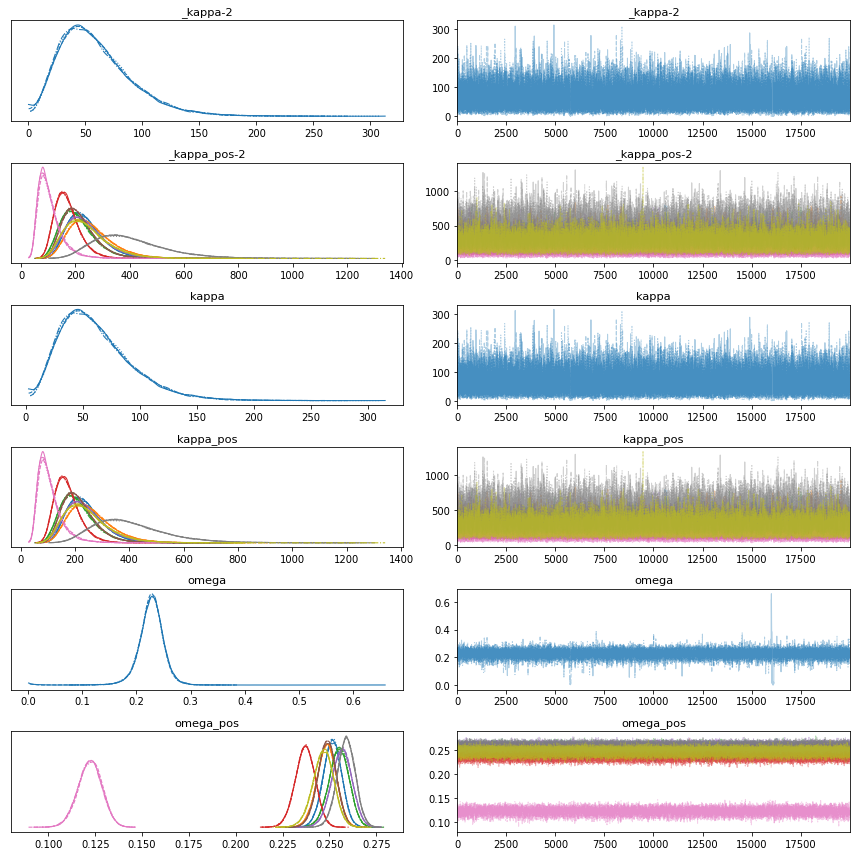

In [11]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(
        position=baseball_df['PriPos'].cat.categories,
        player=baseball_df['Player'],
    ),
    dims=dict(
        omega_pos=['position'],
        kappa_pos=['position'],
        ability=['player'],
    ),
)
az.plot_trace(idata, var_names='~ability')
plt.tight_layout()

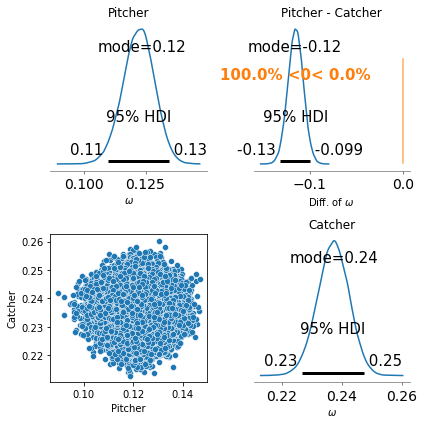

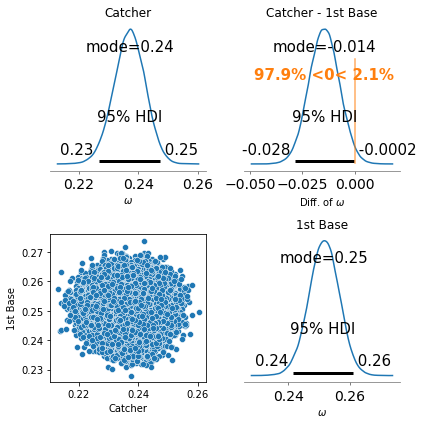

In [12]:
def plot_position_ability(idata: az.InferenceData, positions: list[str]):
    nb_pos = len(positions)
    fig, axes = plt.subplots(nrows=nb_pos, ncols=nb_pos, figsize=(6, 6))

    omega = idata['posterior']['omega_pos']

    for r, c in np.ndindex(axes.shape):
        ax = axes[r, c]
        r_pos = positions[r]
        c_pos = positions[c]

        if r == c:
            az.plot_posterior(
                idata, var_names='omega_pos', coords=dict(position=r_pos),
                hdi_prob=.95, point_estimate='mode', ax=ax)
            ax.set_title(f'{r_pos}')
            ax.set_xlabel('$\\omega$')
        elif r < c:
            diff = (omega.sel(position=r_pos).values
                    - omega.sel(position=c_pos).values)
            az.plot_posterior(
                diff, hdi_prob=.95, point_estimate='mode', ref_val=0, ax=ax)
            ax.set_title(f'{r_pos} - {c_pos}')
            ax.set_xlabel('Diff. of $\\omega$')
        else:
            x = omega.sel(position=c_pos).values.flatten()
            y = omega.sel(position=r_pos).values.flatten()

            sns.scatterplot(x=x, y=y, ax=ax)
            ax.set_xlabel(f'{c_pos}')
            ax.set_ylabel(f'{r_pos}')

    fig.tight_layout()


plot_position_ability(idata, ['Pitcher', 'Catcher'])
plot_position_ability(idata, ['Catcher', '1st Base'])

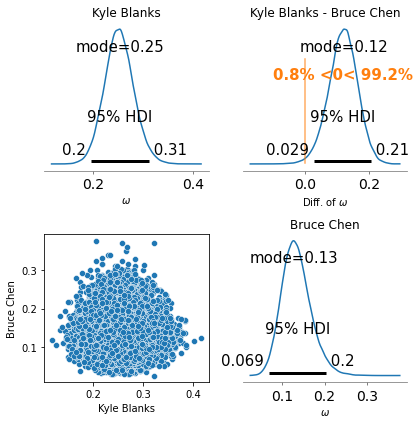

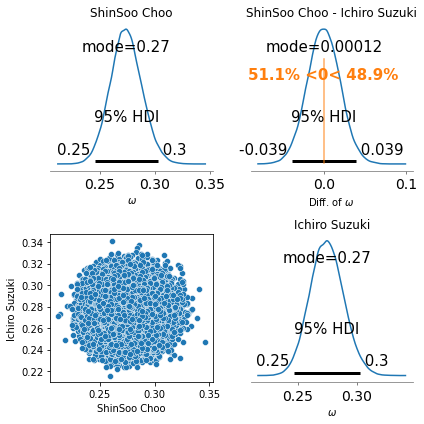

In [13]:
def plot_player_ability(idata: az.InferenceData, players: list[str]):
    nb_players = len(players)
    fig, axes = plt.subplots(
        nrows=nb_players, ncols=nb_players, figsize=(6, 6))

    ability = idata['posterior']['ability']

    for r, c in np.ndindex(axes.shape):
        ax = axes[r, c]
        r_player = players[r]
        c_player = players[c]

        if r == c:
            az.plot_posterior(
                idata, var_names='ability', coords=dict(player=r_player),
                hdi_prob=.95, point_estimate='mode', ax=ax)
            ax.set_title(f'{r_player}')
            ax.set_xlabel('$\\omega$')
        elif r < c:
            diff = (ability.sel(player=r_player).values
                    - ability.sel(player=c_player).values)
            az.plot_posterior(
                diff, hdi_prob=.95, point_estimate='mode', ref_val=0, ax=ax)
            ax.set_title(f'{r_player} - {c_player}')
            ax.set_xlabel('Diff. of $\\omega$')
        else:
            x = ability.sel(player=c_player).values.flatten()
            y = ability.sel(player=r_player).values.flatten()

            sns.scatterplot(x=x, y=y, ax=ax)
            ax.set_xlabel(f'{c_player}')
            ax.set_ylabel(f'{r_player}')

    fig.tight_layout()


plot_player_ability(idata, ['Kyle Blanks', 'Bruce Chen'])
plot_player_ability(idata, ['ShinSoo Choo', 'Ichiro Suzuki'])

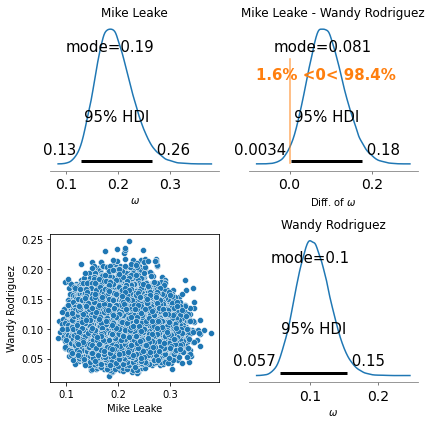

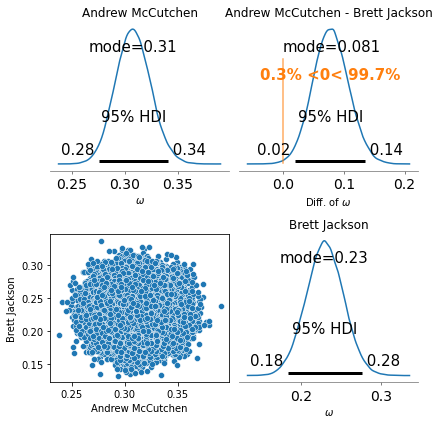

In [14]:
plot_player_ability(idata, ['Mike Leake', 'Wandy Rodriguez'])
plot_player_ability(idata, ['Andrew McCutchen', 'Brett Jackson'])

<AxesSubplot:title={'center':'omega'}>

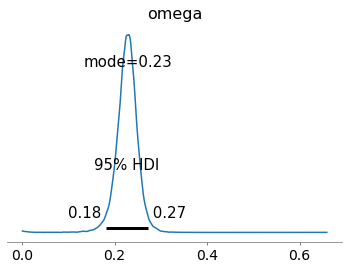

In [15]:
az.plot_posterior(idata, 'omega', hdi_prob=.95, point_estimate='mode')

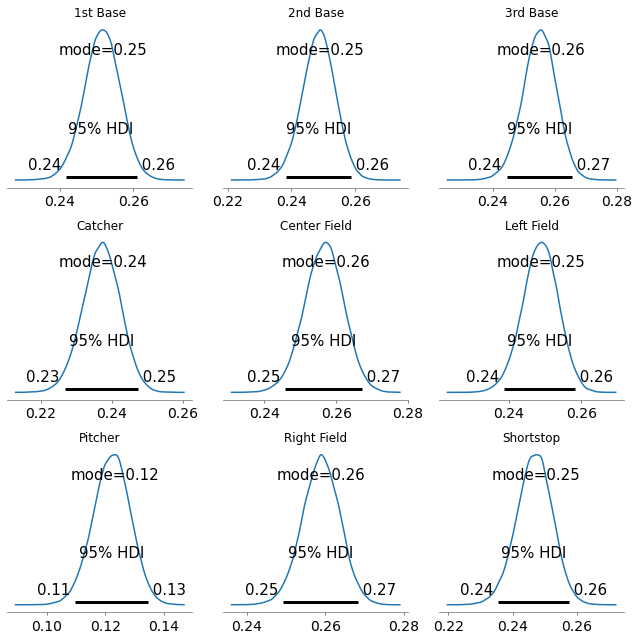

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for ax, position in zip(axes.flatten(), baseball_df['PriPos'].cat.categories):
    az.plot_posterior(
        idata,
        var_names='omega_pos',
        coords=dict(position=position),
        hdi_prob=.95,
        point_estimate='mode',
        ax=ax)
    ax.set_title(position)

fig.tight_layout()